<a href="https://colab.research.google.com/github/JetteKA/BigData/blob/master/ALcluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


Using TensorFlow backend.


In [0]:
n_classes = 10
num_centroids = 5

epochs = 15
batch_size = 50

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [0]:
x_cluster = x_train.reshape((x_train.shape[0], -1))
x_cluster = np.divide(x_cluster, 255.)

In [0]:
kmeans = KMeans(n_clusters=n_classes, init='k-means++')

In [0]:
cluster_distance = kmeans.fit_transform(x_cluster)

In [0]:
closest_to_centroid = cluster_distance.argsort(axis=0)[:num_centroids]

In [0]:
ctc = closest_to_centroid.T

In [0]:
word_label = {0:"T-shirt/top",
              1:"Trouser",
              2:"Pullover",
              3:"Dress",
              4:"Coat",
              5:"Sandal",
              6:"Shirt",
              7:"Sneaker",
              8:"Bag",
              9:"Ankle boot"}

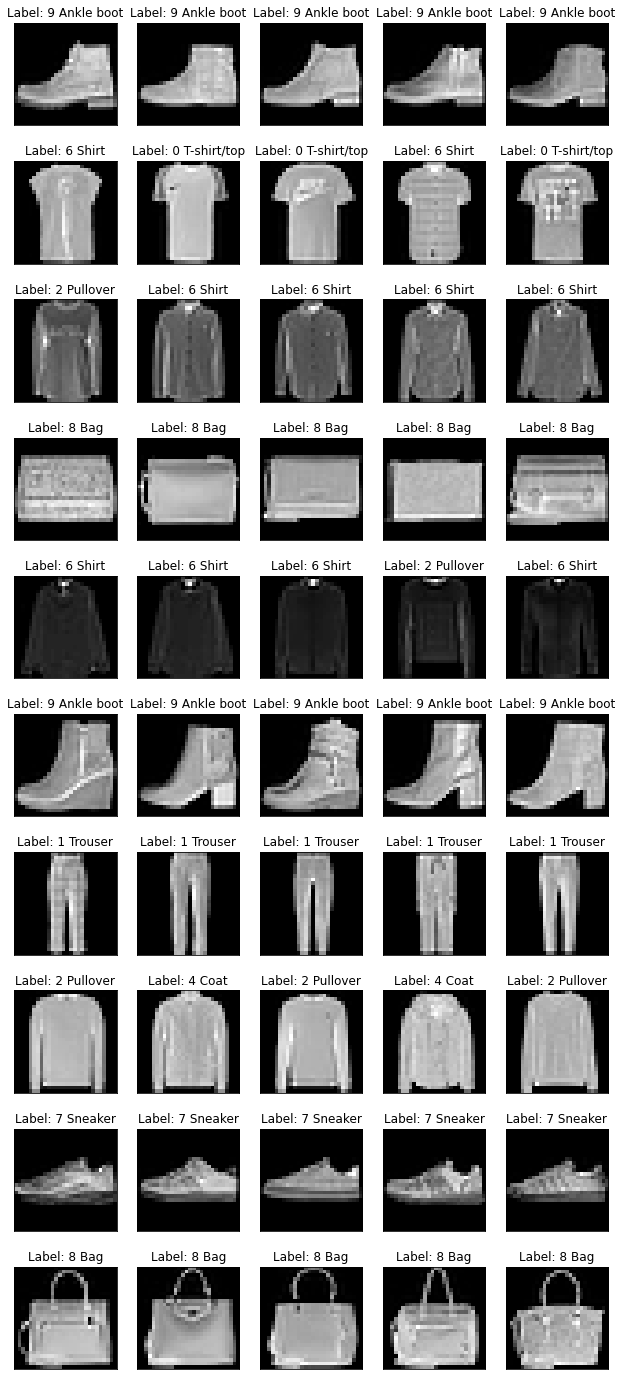

In [0]:
plt.figure(figsize = (15,25))
bottom = 0.35

x_labelled = []
y_labelled = np.empty(int(n_classes*num_centroids))
for i, index in enumerate(ctc.flatten()):

 x_labelled.append(x_train[index])
 y_labelled[i] = y_train[index]

 plt.subplots_adjust(bottom)
 
 plt.subplot(n_classes,num_centroids,i+1, xticks=[], yticks=[])
 plt.title('Label: {} {}'.format(y_train[index], word_label[y_train[index]]),fontsize = 12)
 plt.imshow(x_train[index], cmap='gray')
 plt.savefig("drive/My Drive/BD/onlyActive_5centroids_cluster.png")

In [0]:
x_labelled = np.array(x_labelled)

In [0]:
x_unlabelled = np.delete(x_train, ctc.flatten(), axis=0)
y_unlabelled = np.delete(y_train, ctc.flatten())

In [0]:
def reshape_x_for_cnn(data, img_rows=img_rows, img_cols=img_cols):


  data = data.reshape(data.shape[0], img_rows, img_cols, 1)
  data = data.astype('float32')
  data /=255

  return data

def reshape_y_for_cnn(data, n_classes=n_classes):
  return keras.utils.to_categorical(data, n_classes)

In [0]:
x_test = reshape_x_for_cnn(x_test)

y_test = reshape_y_for_cnn(y_test)

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:

train_acc = []
test_acc = []
train_loss = []
test_loss = []
num_labels = []

In [0]:
def train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled):


  x_label_cnn = reshape_x_for_cnn(x_labelled)


  y_label_cnn = reshape_y_for_cnn(y_labelled)

  model.fit(x_label_cnn, y_label_cnn,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1)
  test_score = model.evaluate(x_test, y_test, verbose=0)
  # print('Test l0ccuracy:', test_score[1])
  test_loss.append(test_score[0])
  test_acc.append(test_score[1])

  train_score = model.evaluate(x_label_cnn, y_label_cnn, verbose=0)
  # print('Train loss:', train_score[0])
  # print('Train accuracy:', train_score[1])
  train_loss.append(train_score[0])
  train_acc.append(train_score[1])

  # print(x_labelled)

  x_unlabel_cnn = reshape_x_for_cnn(x_unlabelled)

  predictions = model.predict(x_unlabel_cnn)

  certainty = np.amax(predictions, axis=1)

  # most_certain = certainty.argsort()[-50:]

  # x_pseudo_label = []
  # y_pseudo_label = []

  # for i, index in enumerate(most_certain):

  #   x_pseudo_label.append(x_unlabelled[index])
  #   y_pseudo_label.append(np.argmax(predictions[index]))
  #   pseudo_label.append(np.argmax(predictions[index]))
  #   actual_label.append(y_unlabelled[index])

  most_uncertain = certainty.argsort()[:50]

  x_label_new = []
  y_label_new = []
  for i, index in enumerate(most_uncertain):

    x_label_new.append(x_unlabelled[index])
    y_label_new.append(y_unlabelled[index])

  y_labelled = np.array(y_labelled.tolist() + y_label_new)
  x_labelled = np.array(x_labelled.tolist() + x_label_new)

  x_unlabelled = np.delete(x_unlabelled, most_uncertain, axis=0)
  y_unlabelled = np.delete(y_unlabelled, most_uncertain)

  return model, x_labelled, y_labelled, x_unlabelled, y_unlabelled

In [0]:
  print('x label:', x_labelled.shape)
  print('y label:', y_labelled.shape)  
  print('x unlabel:', x_unlabelled.shape)
  print('y unlabel:', y_unlabelled.shape)

x label: (50, 28, 28)
y label: (50,)
x unlabel: (59950, 28, 28)
y unlabel: (59950,)


In [0]:
for i in range(100):

  model, x_labelled, y_labelled, x_unlabelled, y_unlabelled = train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





50/50 [==============================] - 13s 257ms/step - loss: 2.3404 - acc: 0.0200
Epoch 2/15
50/50 [==============================] - 0s 211us/step - loss: 2.0810 - acc: 0.2200
Epoch 3/15
50/50 [==============================] - 0s 143us/step - loss: 1.9453 - acc: 0.3600
Epoch 4/15
50/50 [==============================] - 0s 142us/step - loss: 1.6295 - acc: 0.4600
Epoch 5/15
50/50 [==============================] - 0s 154us/step - loss: 1.4152 - acc: 0.5400
Epoch 6/15
50/50 [==============================] - 0s 108us/step - loss: 1.2837 - acc: 0.6800
Epoch 7/15
50/50 [==============================] - 0s 124us/step - loss: 1.3888 - acc: 0.5200
Epoch 8/15
50/50 [==============================] - 0s 152us/step - loss: 1.7881 - acc: 0.3600
Epoch 9/15
50/50 [==============================] - 0s 129us/step - loss: 1.1680 - acc: 0.7600
Epoch 10/15
50/50 [=======================

In [0]:
for i in range(100):

  model, x_labelled, y_labelled, x_unlabelled, y_unlabelled = train_and_label(model, x_labelled, y_labelled, x_unlabelled, y_unlabelled)

Epoch 1/15
5050/5050 [==============================] - 1s 113us/step - loss: 0.1072 - acc: 0.9723
Epoch 2/15
5050/5050 [==============================] - 1s 113us/step - loss: 0.1098 - acc: 0.9709
Epoch 3/15
5050/5050 [==============================] - 1s 116us/step - loss: 0.1161 - acc: 0.9711
Epoch 4/15
5050/5050 [==============================] - 1s 110us/step - loss: 0.0980 - acc: 0.9752
Epoch 5/15
5050/5050 [==============================] - 1s 112us/step - loss: 0.0973 - acc: 0.9731
Epoch 6/15
5050/5050 [==============================] - 1s 112us/step - loss: 0.0850 - acc: 0.9754
Epoch 7/15
5050/5050 [==============================] - 1s 110us/step - loss: 0.0884 - acc: 0.9717
Epoch 8/15
5050/5050 [==============================] - 1s 113us/step - loss: 0.0858 - acc: 0.9758
Epoch 9/15
5050/5050 [==============================] - 1s 113us/step - loss: 0.0885 - acc: 0.9760
Epoch 10/15
5050/5050 [==============================] - 1s 116us/step - loss: 0.0913 - acc: 0.9758
Epoch 11/

In [0]:
num_labels = np.arange(50, 10050, 50)

In [0]:

# MyFile=open('drive/My Drive/BD/onlyAL_50_acc.txt','w')

# for element in test_acc:
#      MyFile.write(str(element))
#      MyFile.write('\n')
# MyFile.close()

In [0]:

# MyFile=open('drive/My Drive/BD/onlyAL_num_labels.txt','w')

# for element in num_labels:
#      MyFile.write(str(element))
#      MyFile.write('\n')
# MyFile.close()

In [0]:

# MyFile=open('drive/My Drive/BD/onlyAL_50_acc_train.txt','w')

# for element in train_acc:
#      MyFile.write(str(element))
#      MyFile.write('\n')
# MyFile.close()

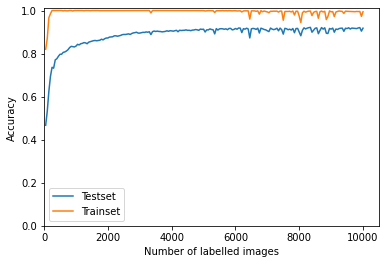

In [0]:
plt.plot(num_labels, test_acc, label="Testset")
plt.plot(num_labels, train_acc, label="Trainset")
plt.xlabel('Number of labelled images')
plt.ylabel("Accuracy")
plt.axis(ymin=0, xmin=0, ymax=1.01)
plt.legend()
# plt.savefig("drive/My Drive/BD/onlyAL.png")